# The frozen dipole model


In this notebook we calculate the equilbrium positions and mode frequencies for a dipole above a type-II superconductor acording to the frozen dipole model as described in https://arxiv.org/abs/1912.10397



## imports and settings

In [1]:
import numpy as np
import pandas as pd
import sys
# from numpy import cos, sin, pi
# from scipy.optimize import minimize, fmin
import pandas as pd
import os
package_path = '../' # add this path to the sys path so that the frozen_dipole model code can be found
if package_path is not None:
    os.sys.path.append(package_path)

    
import json,yaml
import matplotlib.pyplot as plt
from time import sleep
from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm

import matplotlib
%matplotlib inline

FONTSIZE = 20
# some setting for the plots
font = {
#     'family' : 'normal',
        'weight' : 'normal',
        'size'   : FONTSIZE}
matplotlib.rc('lines', linewidth=2)
matplotlib.rc('font', **font)



matplotlib.rc('xtick', labelsize=FONTSIZE) 
matplotlib.rc('ytick', labelsize=FONTSIZE) 
matplotlib.rc('axes', titlesize=FONTSIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=FONTSIZE)    # fontsize of the x and y labels
# auto reload external files, so that we can edit the external .py file and inmediately see the changes here
%load_ext autoreload
%autoreload 2

from matplotlib.ticker import FormatStrFormatter, ScalarFormatter

from frozen_dipole_model import frozen_dipole_model 


import warnings
warnings.filterwarnings('ignore') # ignore warning about negative values in sqrt

In [2]:
physical_parameters = frozen_dipole_model.default_physical_parameters.copy()
parameters = frozen_dipole_model.get_parameters(physical_parameters)

## calculate for fixed particle size and all possible initial conditions

In [3]:
# define ho in um
ho = np.arange(30, 150, 1)
to = np.arange(0, np.pi, 0.025)

normalization = 'a' # choose normalization z hI or acrit (acrit doesn't work so well because of numerics)

len(ho), len(to)

X, Y = np.meshgrid(ho/parameters[normalization]*1e-6, to)
shape = X.shape

position_eq, frequencies, eigen_vectors = [], [], []
step = 10
N_steps = len(X.flatten())
with tqdm(total=N_steps, file=sys.stdout) as pbar:    
    for i, (x, y) in enumerate(zip(X.flatten(), Y.flatten())):
        if i % step==0:
            pbar.set_description('processed: %d' % (1 + i))
            pbar.update(step)
        ret_dict  = frozen_dipole_model.frequencies(ho=x, to=y, physical_parameters=physical_parameters,
                                                 set_y_phi_zero=True, normalization= normalization)

        frequencies.append(ret_dict['eigenfrequencies'])
        position_eq.append(ret_dict['position_eq'])
        eigen_vectors.append(ret_dict['eigen_vectors'].reshape(-1))

    
position_eq = np.array(position_eq)

frequencies = np.array(frequencies)

# normalize to physical units
if position_eq.shape[1]==3:
    position_eq[:,0:2]*=parameters[normalization]*1e6  # um
# normalize to physical units
elif position_eq.shape[1]==5:
    position_eq[:,0:3]*=parameters[normalization]*1e6  # um
else:
    print('something is wrong!')
X, Y = np.meshgrid(ho, to)
Y /=np.pi

processed: 15111: 100%|██████████| 15120/15120 [11:11<00:00, 29.95it/s]


### save data
just because the calculation takes a while better save the data and later load it

In [4]:
tag = 'frozen_dipole_a=22.5um'


df = pd.DataFrame(data = np.hstack([X.reshape(-1,1), Y.reshape(-1,1), position_eq, frequencies, eigen_vectors]),
            columns = ['$h_0$ (um)', '$\\theta_0$ (rad)', 'x_eq (um)', 'z_eq (um)', 't_eq (rad)']
                  + ['$f_{:d}$ (Hz)'.format(i) for i in range(5)]
                  + list(np.array([['v'+str(i)+'_'+str(j) for i in range(5)] for j in range(5)]).reshape(-1)))
                    
df.to_csv('../data/{:s}.csv'.format(tag))  # save data

with open('../data/{:s}.json'.format(tag), 'w') as outfile:
    tmp = json.dump(physical_parameters, outfile, indent=4)
    


### load data

In [5]:
tag = 'frozen_dipole_a=22.5um'

with open('../data/{:s}.json'.format(tag), 'r') as infile:
    physical_parameters = yaml.safe_load(infile)
#     parameters = frozen_dipole_model.get_parameters(physical_parameters)
df = pd.read_csv('../data/{:s}.csv'.format(tag), index_col=0)

### reorder f1 and f4

In [6]:

for h in df['$h_0$ (um)'].unique():
    
    sub_df = df[df['$h_0$ (um)'] == h]
    # look for jumps in f1
    t_max = sub_df['$\\theta_0$ (rad)'].iloc[np.argmax(np.diff(sub_df['$f_1$ (Hz)'].dropna()))]
    t_min = sub_df['$\\theta_0$ (rad)'].iloc[np.argmin(np.diff(sub_df['$f_1$ (Hz)'].dropna()))]
    
#     view = ((df['$\\theta_0$ (rad)'] > t_max) | (df['$\\theta_0$ (rad)'] <= t_min) & df['$h_0$ (um)'] == h)
#     view1 = ((df['$\\theta_0$ (rad)'] > t_max) | (df['$\\theta_0$ (rad)'] <= t_min))
#     view2 = df['$h_0$ (um)'] == h
    
    view1 = (df['$\\theta_0$ (rad)'] > t_max) & (df['$h_0$ (um)'] == h)
    
    view2 = (df['$\\theta_0$ (rad)'] <= t_min) & (df['$h_0$ (um)'] == h)
    
    view = view1 | view2
    
    vals = df.loc[view, ['$f_1$ (Hz)', '$f_4$ (Hz)']].values
    df.loc[view, ['$f_4$ (Hz)', '$f_1$ (Hz)']] = vals

### get data form data frame

In [7]:
X, Y = df[df.keys()[0]].values, df[df.keys()[1]].values
shape = (len(np.unique(Y)), len(np.unique(X)))
X = X.reshape(shape)
Y = Y.reshape(shape)
position_eq, frequencies, eigen_vectors = df[df.keys()[2:5]].values, df[df.keys()[5:10]].values, df[df.keys()[10:]].values

### plot equilibrium position in physical units

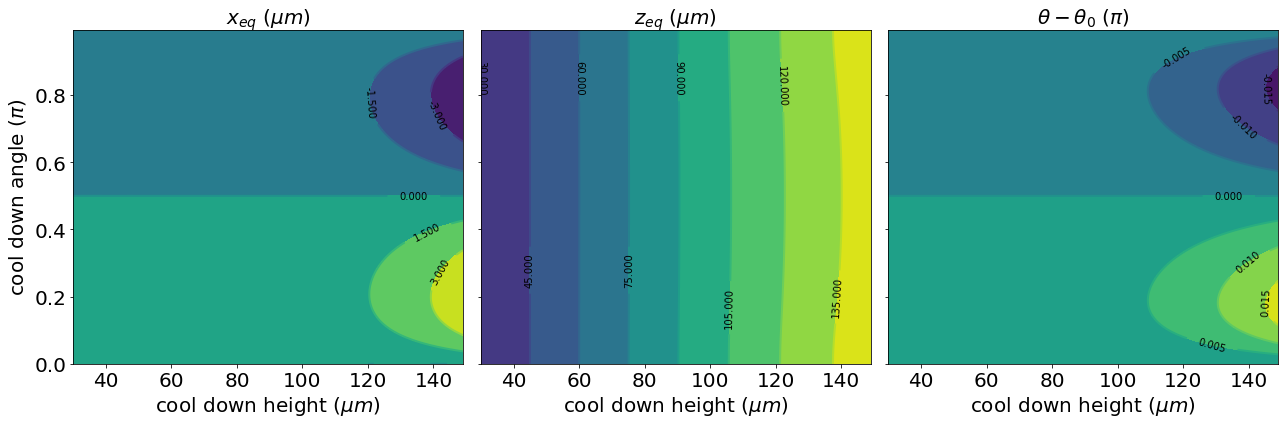

In [8]:

fig, axContour = plt.subplots(1,position_eq.shape[1], figsize=(18, 6), sharey=True)

    # create figure
for i, (ax, direction) in enumerate(zip(axContour, ['$x_{eq}$ ($\mu m$)', '$z_{eq}$ ($\mu m$)', '$\\theta-\\theta_0$ ($\pi$)'])):
        
    if i==2:
        Z = position_eq[:,i].reshape(shape)/np.pi-Y
    else:
        Z = position_eq[:,i].reshape(shape)

    
    # plot contour
    CS =ax.contour(X, Y, Z)
    ax.clabel(CS, inline=1, fontsize=10, colors='k')
    
#     CS =plt.pcolor(X, Y, Z)
    CS =ax.contourf(X, Y, Z)
#     cb = ax.colorbar()
#     cb.set_label(quantity)

        

    ax.set_xlabel('cool down height ($\mu m$)')
    ax.set_title(direction)
    if i==0:
        ax.set_ylabel('cool down angle ($\pi$)')

fig.tight_layout()
plt.draw()
plt.show()

### plot equilibrium position in normalized units

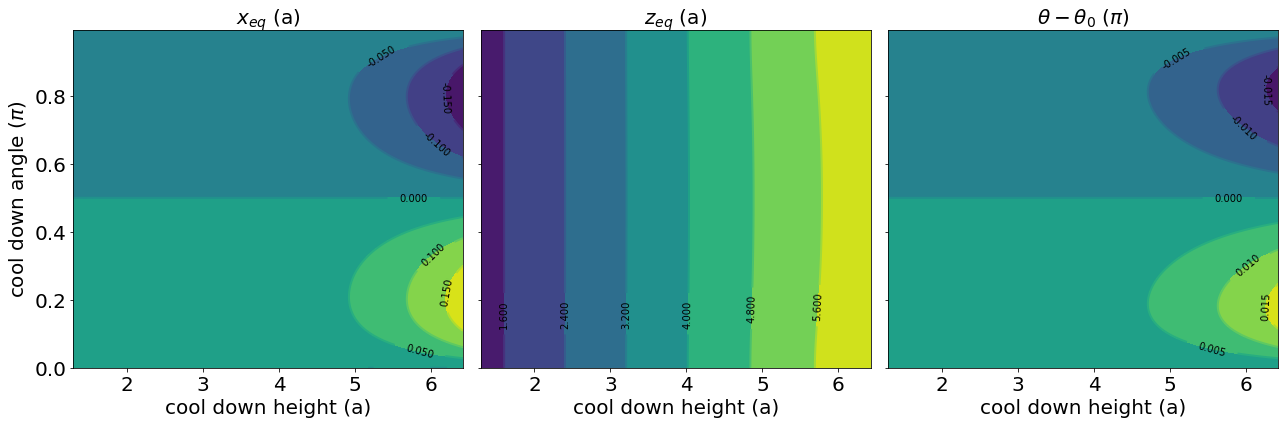

In [9]:
normalize=True
normalization = 'a' # choose normalization z hI or acrit (acrit doesn't work so well because of numerics)

if normalize:
    norm = parameters[normalization]*1e6
fig, axContour = plt.subplots(1,position_eq.shape[1], figsize=(18, 6), sharey=True)

    # create figure
for i, (ax, direction) in enumerate(zip(axContour, ['$x_{eq}$ (a)', '$z_{eq}$ (a)', '$\\theta-\\theta_0$ ($\pi$)'])):
    


    if i==2:
        Z = position_eq[:,i].reshape(shape)/np.pi-Y
#     elif i==1:
    else:
        Z = position_eq[:,i].reshape(shape)/parameters['a']*1e-6
#         Z = position_eq[:,i].reshape(shape)

    if normalize:
        # plot contour
        CS =ax.contour(X/norm, Y, Z)
        ax.clabel(CS, inline=1, fontsize=10, colors='k')

    #     CS =plt.pcolor(X, Y, Z)
        CS =ax.contourf(X/norm, Y, Z)
    else:
        CS =ax.contour(X, Y, Z)
        ax.clabel(CS, inline=1, fontsize=10, colors='k')
        CS =ax.contourf(X, Y, Z)
#     cb = ax.colorbar()
#     cb.set_label(quantity)

        
    if normalize:
        ax.set_xlabel('cool down height ('+normalization+')')
    else:
        ax.set_xlabel('cool down height ($\mu m$)')
    ax.set_title(direction)
    if i==0:
        ax.set_ylabel('cool down angle ($\pi$)')

fig.tight_layout()
plt.draw()
plt.show()
fig.savefig('../'+'images/equilibrium_a_{:0.1f}um'.format(parameters['a']*1e6).replace('.', '_')+'.png', transparent=True )

### plot mode frequencies

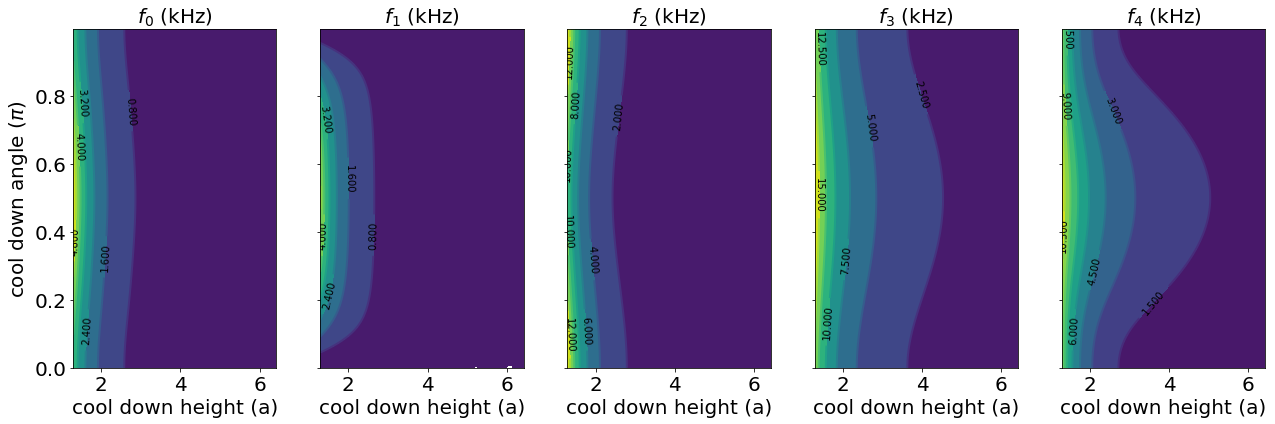

In [10]:

fig, axContour = plt.subplots(1,frequencies.shape[1], figsize=(18, 6), sharey=True)

    # create figure
for i, (ax, direction) in enumerate(zip(axContour, ['$f_{:d}$ (kHz)'.format(i) for i in range(5)])):
    
    
    Z = frequencies[:,i].reshape(shape)*1e-3

    
    # plot contour
    CS =ax.contour(X/parameters['a']*1e-6, Y, Z)
    ax.clabel(CS, inline=1, fontsize=10, colors='k')
    
#     CS =plt.pcolor(X, Y, Z)
    CS =ax.contourf(X/parameters['a']*1e-6, Y, Z)
#     cb = ax.colorbar()
#     cb.set_label(quantity)

        

    ax.set_xlabel('cool down height (a)')
    ax.set_title(direction)
    if i==0:
        ax.set_ylabel('cool down angle ($\pi$)')

fig.tight_layout()
plt.draw()
plt.show()
fig.savefig('../'+'images/frequencies_a_{:0.1f}um'.format(parameters['a']*1e6).replace('.', '_')+'.png', transparent=True )

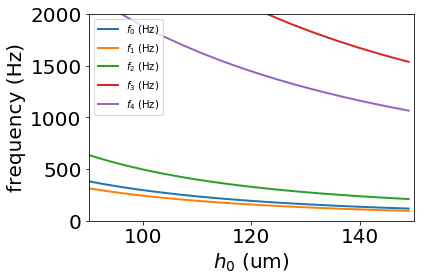

In [11]:
theta_c = df['$\\theta_0$ (rad)'].unique()[62]
sub_df = df[df['$\\theta_0$ (rad)'] == theta_c]

fig = plt.figure()
# sub_df.plot(x='$h_0$ (um)', y=['$f_{:d}$ (Hz)'.format(i) for i in range(5)], legend=False)
for i in range(5):
    plt.plot(sub_df['$h_0$ (um)'], sub_df['$f_{:d}$ (Hz)'.format(i)], label = '$f_{:d}$ (Hz)'.format(i))
# plt.legend(loc = (1,0.25))
plt.xlabel('$h_0$ (um)')
plt.ylabel('frequency (Hz)')
plt.legend(loc = 'best')
plt.ylim(0,2000)
plt.xlim(90,150)
# plt.plot(sub_df['theta_0 (rad)'], sub_df['$f_0$ (Hz)])


plt.tight_layout()
plt.show()
fig.savefig('../'+'images/frequencies_a_{:0.1f}um_theta_c_{:02.0f}deg'.format(parameters['a']*1e6, theta_c*180).replace('.', '_')+'.png', transparent=True )

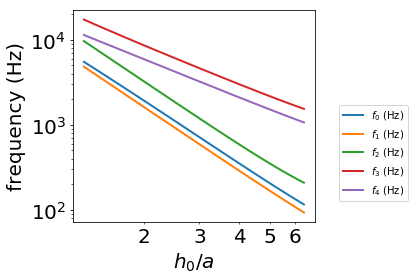

In [12]:
norm_to_a = True # x axis normalized to radius a

a_um = physical_parameters['radius']*1e6  # radius in um




theta_c = df['$\\theta_0$ (rad)'].unique()[62]
sub_df = df[df['$\\theta_0$ (rad)'] == theta_c]

fig, ax = plt.subplots(1,1)



if norm_to_a:
    x = sub_df['$h_0$ (um)'] / a_um
    x_label = '$h_0 / a$'
else:
    x = sub_df['$h_0$ (um)']
    x_label = '$h_0$ (um)'

for i in range(5):
    ax.loglog(x, sub_df['$f_{:d}$ (Hz)'.format(i)], label = '$f_{:d}$ (Hz)'.format(i))
# plt.legend(loc = (1,0.25))

# ax.xaxis.set_minor_formatter(ScalarFormatter())
ax.xaxis.set_minor_formatter(FormatStrFormatter('%.0f'))
ax.set_xlabel(x_label)
ax.set_ylabel('frequency (Hz)')
plt.legend(loc = (1.1, 0.1))
# plt.ylim(0,2000)
# plt.xlim(90,150)
# plt.plot(sub_df['theta_0 (rad)'], sub_df['$f_0$ (Hz)])
plt.tight_layout()
plt.show()
fig.savefig('../'+'images/frequencies_a_{:0.1f}um_theta_c_{:02.0f}deg_log'.format(parameters['a']*1e6, theta_c*180).replace('.', '_')+'.png', transparent=True )

## calculate for fixed initial condition and varying particle size

In [13]:
physical_parameters = frozen_dipole_model.default_physical_parameters
normalization = 'a' # choose normalization z hI or acrit (acrit doesn't work so well because of numerics)

ho = 3 # in units of radius a
to = 0.5 * np.pi
radii = np.logspace(-1,2, 25) # range of radii on a log scale
# ======== end input ========

position_eq, frequencies, eigen_vectors = [], [], []

with tqdm(total=len(radii), file=sys.stdout) as pbar:  
    for i, a in enumerate(radii):
        physical_parameters['radius'] = a*1e-6

        pbar.set_description('processed: %d' % (1 + i))
        pbar.update(i)
        
        parameters = frozen_dipole_model.get_parameters(physical_parameters)

        ret_dict  = frozen_dipole_model.frequencies(ho=ho, to=to, physical_parameters=physical_parameters,
                                                     set_y_phi_zero=True, normalization=normalization)

        frequencies.append(ret_dict['eigenfrequencies'])
        position_eq.append(ret_dict['position_eq'])
        eigen_vectors.append(ret_dict['eigen_vectors'].reshape(-1))

    position_eq = np.array(position_eq)
    frequencies = np.array(frequencies)

processed: 25: : 300it [00:01, 260.11it/s]                   


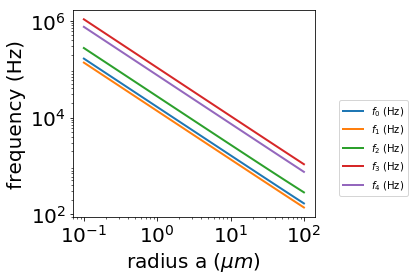

In [14]:
fig, ax = plt.subplots()
for i, f in enumerate(frequencies.T):

    ax.loglog(radii, f, label = '$f_{:d}$ (Hz)'.format(i))
ax.set_xlabel('radius a ($\mu m$)')
ax.set_ylabel('frequency (Hz)')
# plt.title('initial conditions ho={:0.1f}a, to={:0.0f}deg'.format(ho, to/np.pi*180))
plt.xticks([0.1, 1, 10, 100])
plt.yticks([1e2, 1e4, 1e6])
# ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
plt.legend(loc = (1.1, 0.1))
plt.tight_layout()
fig.savefig('../'+'images/frequencies_h_c_{:0.1f}a_theta_c_{:02.0f}deg_log'.format(ho, to*180/np.pi).replace('.', '_')+'.png', transparent=True )